_Author: Piotr Kaniewski, 25.11.2024_
# E2E stability and evaluation comparison

__AIM:__ Compare Node2Vec, OpenAI and PubMedBERT embeddings in terms of stability and performance. Related to issue [#595](https://github.com/everycure-org/matrix/issues/595)

Metrics to be used: standard evaluation metrics, commonality at k, stability F1, hypergeometric test, spearman correlation for k.

__TL;DR:__ Node2Vec still outperforms remaining models. Only for some metrics which are clinical trials related, OpenAI-GS combination performs better which could potentially be a sign of data leakage (however we have no information on what data and what time range was used for training `text-embeddings-3-small` model). In terms of stability, xg_ensemble models 


__References:__
MLFlow runs and results (table created below manually)
- GS-PubMedBERT run: [feature-attribute-embeddings-strategy-4c53361f](https://mlflow.platform.dev.everycure.org/#/experiments/3510/runs/cc22f33877904579b530605ad732d3a5)
- GS-OpenAI run: [feature-attribute-embeddings-strategy-93d6bec0 ](https://mlflow.platform.dev.everycure.org/#/experiments/4100/runs/bfafbb14c0f7455395bc0d3dbbf73236)
- N2V run: [feature-attribute-embeddings-strategy-94019e37](https://mlflow.platform.dev.everycure.org/#/experiments/3751/runs/c30203b30ae64d93bf4622e45830b248)
- Notebook and functions: https://github.com/everycure-org/lab-notebooks/tree/main/stability

### Load dependencies

In [5]:
import pandas as pd
from stability_utils import * 
import pickle 

### Eval comparison

In [8]:
# Function to highlight the best model for each metric
mlflow_df = pd.DataFrame({
    'model': ['rf-gs-pubmed', 'xg-ensemble-gs-pubmed', 'rf-gs-openai', 'xg-ensemble-gs-openai', 'xg-ensemble-n2v'],
    'macro-f1':[0.59, 0.53, 0.60, 0.58, 0.60],
    'simple-f1':[0.82, 0.70, 0.84, 0.81, 0.84],
    'accuracy':[0.85,0.77,0.90,0.83, 0.87],
    'auroc':[0.90, 0.95,0.93,0.98, 0.99],
    'mrr':[0.06, 0.18,0.14,0.31,0.38],
    'hit-2':[0.05, 0.16,0.13,0.29,0.35],
    'hit-10':[0.09,0.28,0.20,0.46,0.57],
    'hit-100':[0.22, 0.57,0.49,0.76,0.85],
    'recall-1000': [0.003,0.04,0.03,0.11,0.12],
    'recall-10000': [0.03,0.15,0.12,0.32,0.44],
    'recall-100000': [0.16,0.42,0.33,0.63,0.76],
    'recall-1000000': [0.64,0.76,0.72,0.87, 0.94],
    'trial-simple-f1':[0.71,0.25,0.65,0.67,0.38],
    'trial-accuracy':[0.55, 0.2,0.49,0.24, 0.27],
    'trial-auroc':[0.80, 0.86,0.77,0.92,0.91],
    'trial-mrr':[0.00, 0.01,0.03,0.06,0.04],
    'trial-hit-2': [0,0,0.025,0.05,0.025],
    'trial-hit-10': [0,0.025, 0.025, 0.075,0.075],
    'trial-hit-100':[0.05, 0.175,0.175,0.275,0.4],
    'trial-recall-1000': [0.0,0.0,0,0,0.03],
    'trial-recall-10000': [0.0,0.03,0.00,0.05,0.05],
    'trial-recall-100000': [0.08,0.08,0.10,0.15,0.26],
    'trial-recall-1000000': [0.44,0.38,0.44,0.44,0.64]
})
mlflow_df_transposed = mlflow_df.T
mlflow_df_transposed.columns = mlflow_df_transposed.iloc[0]
mlflow_df_transposed = mlflow_df_transposed.drop(mlflow_df_transposed.index[0])
mlflow_df_transposed.style.apply(highlight_max, axis=1)

model,rf-gs-pubmed,xg-ensemble-gs-pubmed,rf-gs-openai,xg-ensemble-gs-openai,xg-ensemble-n2v
macro-f1,0.590000,0.530000,0.600000,0.580000,0.600000
simple-f1,0.820000,0.700000,0.840000,0.810000,0.840000
accuracy,0.850000,0.770000,0.900000,0.830000,0.870000
auroc,0.900000,0.950000,0.930000,0.980000,0.990000
mrr,0.060000,0.180000,0.140000,0.310000,0.380000
hit-2,0.050000,0.160000,0.130000,0.290000,0.350000
hit-10,0.090000,0.280000,0.200000,0.460000,0.570000
hit-100,0.220000,0.570000,0.490000,0.760000,0.850000
recall-1000,0.003000,0.040000,0.030000,0.110000,0.120000
recall-10000,0.030000,0.150000,0.120000,0.320000,0.440000


In [9]:
# Drop n2v to check which is better
mlflow_df_transposed.drop('xg-ensemble-n2v',axis=1).style.apply(highlight_max, axis=1)

model,rf-gs-pubmed,xg-ensemble-gs-pubmed,rf-gs-openai,xg-ensemble-gs-openai
macro-f1,0.590000,0.530000,0.600000,0.580000
simple-f1,0.820000,0.700000,0.840000,0.810000
accuracy,0.850000,0.770000,0.900000,0.830000
auroc,0.900000,0.950000,0.930000,0.980000
mrr,0.060000,0.180000,0.140000,0.310000
hit-2,0.050000,0.160000,0.130000,0.290000
hit-10,0.090000,0.280000,0.200000,0.460000
hit-100,0.220000,0.570000,0.490000,0.760000
recall-1000,0.003000,0.040000,0.030000,0.110000
recall-10000,0.030000,0.150000,0.120000,0.320000


Although PubMedBERT is a fine-tuned biomedical LLM, for embedding generation it is outperformed by OpenAI. This makes sense as the PubMEDBERT used by Chunyu is not actually fine-tuned to generate emmbeddings while OpenAI model is.

Node2Vec still outperforms remaining models. Only for some metrics which are clinical trials related, OpenAI-GS combination performs better which could potentially be a sign of data leakage (however we have no information on what data and what time range was used for training `text-embeddings-3-small` model).

### Stability analysis:

#### Load data

In [12]:
RUN_1_NAME = 'xg-ensemble-gs-openai'
RUN_1_PATH = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.5-rtx.gs-openai/datasets/matrix_generation/model_output/xg_ensemble/matrix_predictions'

RUN_2_NAME = 'xg-ensemble-n2v'
RUN_2_PATH = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/tests/v0.2.5-rtx.n2v-random-test/datasets/matrix_generation/model_output/xg_ensemble/matrix_predictions'

RUN_3_NAME = 'xg-ensemble-gs-pb'
RUN_3_PATH = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.5-rtx.gs-pubmed/datasets/matrix_generation/model_output/xg_ensemble/matrix_predictions'

RUN_4_NAME = 'rf-gs-openai'
RUN_4_PATH = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.5-rtx.gs-openai/datasets/matrix_generation/model_output/rf/matrix_predictions'

RUN_5_NAME = 'rf-gs-pubmed'
RUN_5_PATH = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.5-rtx.gs-pubmed/datasets/matrix_generation/model_output/rf/matrix_predictions'


K_VALUES = [1000] # TODO: add 10000, 100000, 1000000; note it takes a while to run 1000 for 5 runs

# FINAL DICT - adjust accordingly
run_dict = {RUN_1_NAME: RUN_1_PATH,
            RUN_2_NAME: RUN_2_PATH,
            RUN_3_NAME: RUN_3_PATH,
            RUN_4_NAME: RUN_4_PATH,
            RUN_5_NAME: RUN_5_PATH}



In [ ]:
#load data
for key in run_dict.keys():
    print('Loading: ',key)
    df = pd.read_parquet(run_dict[key])
    if 'pair' not in df.columns:
        df['pair'] = df['source'] + '_' + df['target']
    run_dict[key] = df


#### Analysis
Note running those takes a while when they are simply looped; better and proper parallelization is needed for actual production.

In [6]:
# Function to choose pairs which are consistent across all runs (matrix output might differ between runs due to different train-test splits, GT lists etc)
relevant_pairs = choose_relevant_pairs(*run_dict.values())


In [ ]:
# commonality node
commonality_dict = {}
for k in K_VALUES:
    commonality_dict[k]={}
    for name_1, model_1 in run_dict.items():
        commonality_dict[k][name_1]={}
        for name_2, model_2 in run_dict.items():
            print(name_1, ' - ', name_2, '-k', k)
            commonality = give_S_k(model_1, model_2, k, relevant_pairs)
            commonality_dict[k][name_1][name_2]=commonality

with open('scratch/stability/commonality_dict.pkl', 'wb') as f:
    pickle.dump(commonality_dict, f)

In [11]:
# spearman node
spearman_dict = {}
for k in K_VALUES:
    spearman_dict[k]={}
    for name_1, model_1 in run_dict.items():
        spearman_dict[k][name_1]={}
        for name_2, model_2 in run_dict.items():
            print(name_1, ' - ', name_2, '-k', k)
            spearman = give_spearman_k(model_1, model_2, k, relevant_pairs)
            spearman_dict[k][name_1][name_2]=spearman['correlation']
            spearman_dict[k][name_1][name_2+'_pvalue']=spearman['pvalue']

with open('scratch/stability/spearman_dict.pkl', 'wb') as f:
    pickle.dump(spearman_dict, f)

xg-ensemble-gs-openai  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-openai  -  rf-gs-openai -k 1000
xg-ensemble-gs-openai  -  rf-gs-pubmed -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-n2v  -  xg-ensemble-n2v -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-n2v  -  rf-gs-openai -k 1000
xg-ensemble-n2v  -  rf-gs-pubmed -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-pb  -  rf-gs-openai -k 1000
xg-ensemble-gs-pb  -  rf-gs-pubmed -k 1000
rf-gs-openai  -  xg-ensemble-gs-openai -k 1000
rf-gs-openai  -  xg-ensemble-n2v -k 1000
rf-gs-openai  -  xg-ensemble-gs-pb -k 1000
rf-gs-openai  -  rf-gs-openai -k 1000
rf-gs-openai  -  rf-gs-pubmed -k 1000
rf-gs-pubmed  -  xg-ensemble-gs-openai -k 1000
rf-gs-pubmed  -  xg-ensemble-n2v -k 1000

In [14]:
# Calculate stability metrics

relevant_pairs = choose_relevant_pairs(*run_dict.values())

# commonality node
hypergeom_dict = {}
for k in K_VALUES:
    hypergeom_dict[k]={}
    for name_1, model_1 in run_dict.items():
        hypergeom_dict[k][name_1]={}
        for name_2, model_2 in run_dict.items():
            print(name_1, ' - ', name_2, '-k', k)
            hyper = hypergeom_test(model_1, model_2, k, relevant_pairs)
            hypergeom_dict[k][name_1][name_2]=hyper['enrichment']
            hypergeom_dict[k][name_1][name_2+'_pvalue']=hyper['pvalue']

with open('scratch/stability/hypergeom_dict.pkl', 'wb') as f:
    pickle.dump(hypergeom_dict, f)

xg-ensemble-gs-openai  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-openai  -  rf-gs-openai -k 1000
xg-ensemble-gs-openai  -  rf-gs-pubmed -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-n2v  -  xg-ensemble-n2v -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-n2v  -  rf-gs-openai -k 1000
xg-ensemble-n2v  -  rf-gs-pubmed -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-pb  -  rf-gs-openai -k 1000
xg-ensemble-gs-pb  -  rf-gs-pubmed -k 1000
rf-gs-openai  -  xg-ensemble-gs-openai -k 1000
rf-gs-openai  -  xg-ensemble-n2v -k 1000
rf-gs-openai  -  xg-ensemble-gs-pb -k 1000
rf-gs-openai  -  rf-gs-openai -k 1000
rf-gs-openai  -  rf-gs-pubmed -k 1000
rf-gs-pubmed  -  xg-ensemble-gs-openai -k 1000
rf-gs-pubmed  -  xg-ensemble-n2v -k 1000

In [4]:
# Calculate stability metrics

relevant_pairs = choose_relevant_pairs(*run_dict.values())

# commonality node
f1_dict = {}
for k in K_VALUES:
    f1_dict[k]={}
    for name_1, model_1 in run_dict.items():
        f1_dict[k][name_1]={}
        for name_2, model_2 in run_dict.items():
            print(name_1, ' - ', name_2, '-k', k)
            spearman = give_spearman_k(model_1, model_2, k, relevant_pairs)
            commonality = give_S_k(model_1, model_2, k, relevant_pairs)
            f1 = give_stability_f1(commonality, spearman['correlation'])
            f1_dict[k][name_1][name_2]=f1

with open('scratch/stability/f1_dict.pkl', 'wb') as f:
    pickle.dump(f1_dict, f)


xg-ensemble-gs-openai  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-openai  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-openai  -  rf-gs-openai -k 1000
xg-ensemble-gs-openai  -  rf-gs-pubmed -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-n2v  -  xg-ensemble-n2v -k 1000
xg-ensemble-n2v  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-n2v  -  rf-gs-openai -k 1000
xg-ensemble-n2v  -  rf-gs-pubmed -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-openai -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-n2v -k 1000
xg-ensemble-gs-pb  -  xg-ensemble-gs-pb -k 1000
xg-ensemble-gs-pb  -  rf-gs-openai -k 1000
xg-ensemble-gs-pb  -  rf-gs-pubmed -k 1000
rf-gs-openai  -  xg-ensemble-gs-openai -k 1000
rf-gs-openai  -  xg-ensemble-n2v -k 1000
rf-gs-openai  -  xg-ensemble-gs-pb -k 1000
rf-gs-openai  -  rf-gs-openai -k 1000
rf-gs-openai  -  rf-gs-pubmed -k 1000
rf-gs-pubmed  -  xg-ensemble-gs-openai -k 1000
rf-gs-pubmed  -  xg-ensemble-n2v -k 1000

### Heatmaps visualisations

In [6]:
with open('/Users/piotrkaniewski/work/matrix/pipelines/matrix/scratch/stability/commonality_dict.pkl', 'rb') as f:
    commonality_dict = pickle.load(f)
with open('/Users/piotrkaniewski/work/matrix/pipelines/matrix/scratch/stability/spearman_dict.pkl', 'rb') as f:
    spearman_dict = pickle.load(f)
with open('/Users/piotrkaniewski/work/matrix/pipelines/matrix/scratch/stability/hypergeom_dict.pkl', 'rb') as f:
    hypergeom_dict = pickle.load(f)
with open('/Users/piotrkaniewski/work/matrix/pipelines/matrix/scratch/stability/f1_dict.pkl', 'rb') as f:
    f1_dict = pickle.load(f)


No p-values provided


(                      xg-ensemble-gs-openai xg-ensemble-n2v xg-ensemble-gs-pb  \
 xg-ensemble-gs-openai                   1.0           0.126             0.055   
 xg-ensemble-n2v                       0.126             1.0             0.036   
 xg-ensemble-gs-pb                     0.055           0.036               1.0   
 rf-gs-openai                          0.015            0.01             0.006   
 rf-gs-pubmed                          0.004           0.003             0.009   
 
                       rf-gs-openai rf-gs-pubmed  
 xg-ensemble-gs-openai        0.015        0.004  
 xg-ensemble-n2v               0.01        0.003  
 xg-ensemble-gs-pb            0.006        0.009  
 rf-gs-openai                   1.0        0.078  
 rf-gs-pubmed                 0.078          1.0  ,
 <Figure size 640x480 with 2 Axes>)

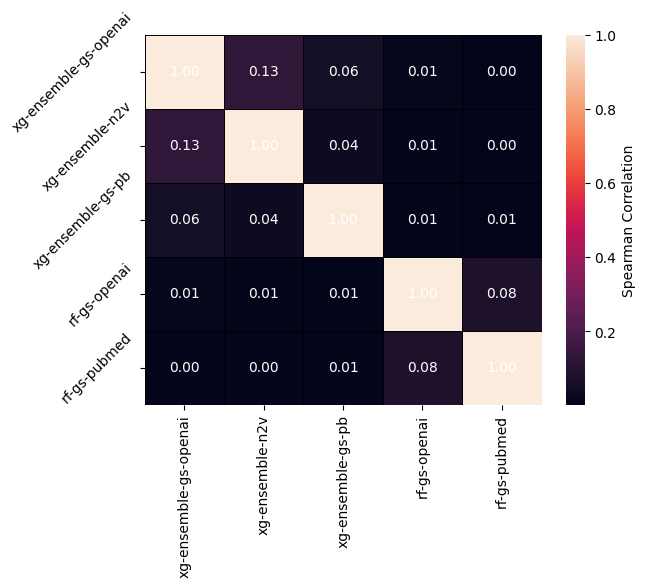

In [25]:
# Commonality at k 
score_heatmap(**commonality_dict[1000])

Highest overlap between xg_ensemble node2vec and xg_ensemble GS-OpenAI which are also our top performing models - good sign

(                      xg-ensemble-gs-openai xg-ensemble-n2v xg-ensemble-gs-pb  \
 xg-ensemble-gs-openai                   1.0        0.050535         -0.002742   
 xg-ensemble-n2v                    0.050535             1.0         -0.068211   
 xg-ensemble-gs-pb                 -0.002742       -0.068211               1.0   
 rf-gs-openai                            0.1        0.139394          0.542857   
 rf-gs-pubmed                            0.2             0.5          0.533333   
 
                       rf-gs-openai rf-gs-pubmed  
 xg-ensemble-gs-openai          0.1          0.2  
 xg-ensemble-n2v           0.139394          0.5  
 xg-ensemble-gs-pb         0.542857     0.533333  
 rf-gs-openai                   1.0    -0.020853  
 rf-gs-pubmed             -0.020853          1.0  ,
 <Figure size 640x480 with 2 Axes>)

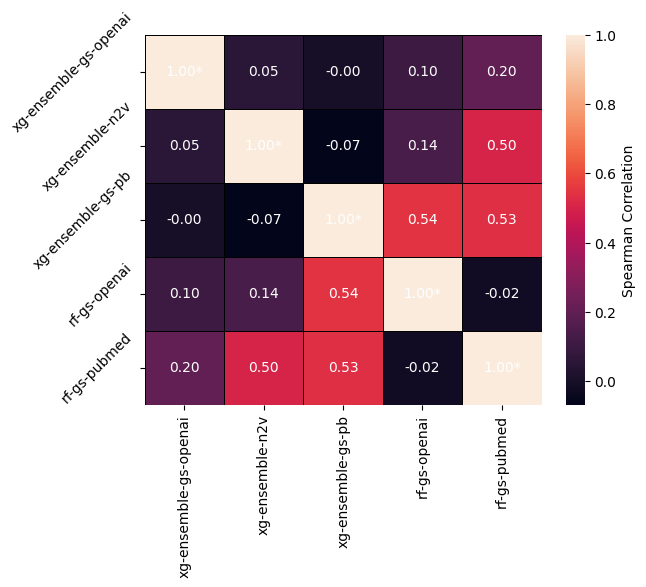

In [7]:
# Spearman at k 
score_heatmap(p_values=True,**spearman_dict[1000])

No significant correlation between spearman and commonality at k. Not necessarily surprising as there might be few pairs which are consistent across all runs when we use k=1k and ranking metrics can be a bit more 'sensitive' than commonality

(                      xg-ensemble-gs-openai xg-ensemble-n2v xg-ensemble-gs-pb  \
 xg-ensemble-gs-openai              28164.94      3548.78244         1549.0717   
 xg-ensemble-n2v                  3548.78244        28164.94        1013.93784   
 xg-ensemble-gs-pb                 1549.0717      1013.93784          28164.94   
 rf-gs-openai                       422.4741        281.6494         168.98964   
 rf-gs-pubmed                      112.65976        84.49482         253.48446   
 
                       rf-gs-openai rf-gs-pubmed  
 xg-ensemble-gs-openai     422.4741    112.65976  
 xg-ensemble-n2v           281.6494     84.49482  
 xg-ensemble-gs-pb        168.98964    253.48446  
 rf-gs-openai              28164.94   2196.86532  
 rf-gs-pubmed            2196.86532     28164.94  ,
 <Figure size 640x480 with 2 Axes>)

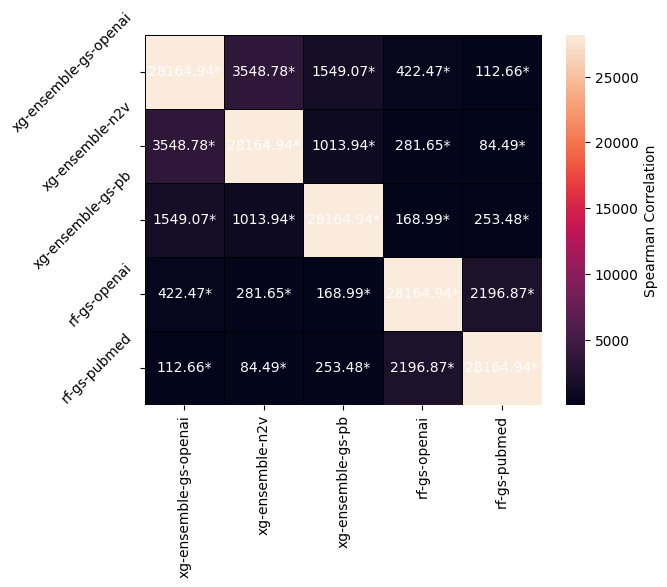

In [27]:
# Hypergeom at k 
score_heatmap(p_values=True, **hypergeom_dict[1000])

Statistical overlap for all samples and high enrichment; the ranked lists are not random and high enrichment indicates commonality between the models. Consistent with commonality at k results which showed non-zero results for all models.

No p-values provided


(                      xg-ensemble-gs-openai xg-ensemble-n2v xg-ensemble-gs-pb  \
 xg-ensemble-gs-openai                   1.0        0.072137         -0.005771   
 xg-ensemble-n2v                    0.072137             1.0          0.152469   
 xg-ensemble-gs-pb                 -0.005771        0.152469               1.0   
 rf-gs-openai                       0.026087        0.018661          0.011869   
 rf-gs-pubmed                       0.007843        0.005964          0.017701   
 
                       rf-gs-openai rf-gs-pubmed  
 xg-ensemble-gs-openai     0.026087     0.007843  
 xg-ensemble-n2v           0.018661     0.005964  
 xg-ensemble-gs-pb         0.011869     0.017701  
 rf-gs-openai                   1.0    -0.056923  
 rf-gs-pubmed             -0.056923          1.0  ,
 <Figure size 640x480 with 2 Axes>)

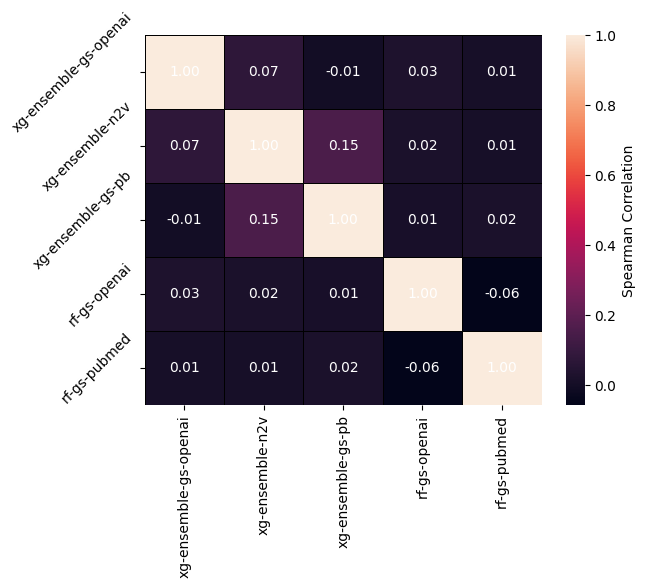

In [8]:
# Stability F1 at k 
score_heatmap(**f1_dict[1000])

Stability F1 would indicates that xg ensemble between XG-Ensemble-GS-OpenAI and XG-Ensemble-N2V are the most similar and stable wrt each other. Then xg_ensemble-n2 and xg_ensemble-openai - so we can see clear similarity between xg ensemble models.  Interesting that n2v and pubmedbert seemed to be the most similar to each other. 

Also for F1 stability metric, which is quite experimental, we will need to account for negative correlation as it affects the metric value (as we divide by the sum)

In [9]:
# TODO: re-do it once I refactor the code to make it more efficient (this will take ages to run)
# fig = commonality_curves(max_k=100, relevant_pairs=relevant_pairs, **run_dict)

### Distribution plots for full matrix

(<Figure size 1000x600 with 1 Axes>, <Figure size 500x1500 with 5 Axes>)

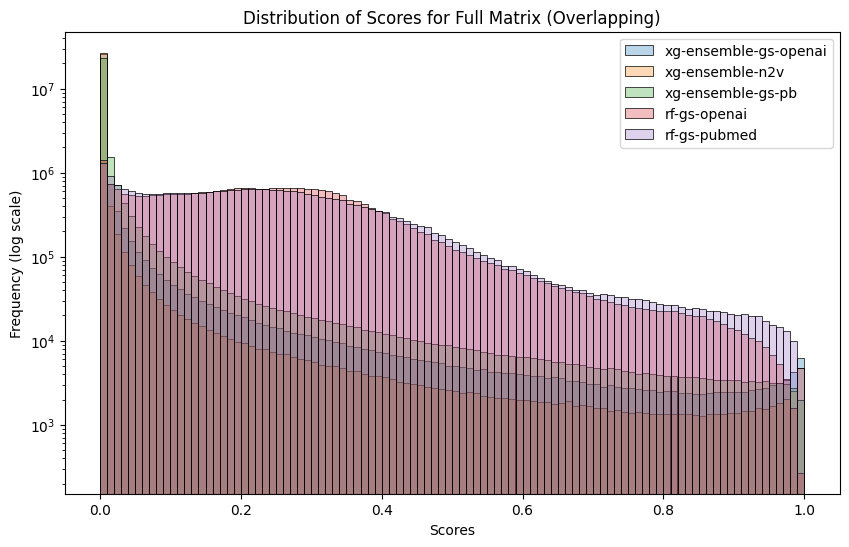

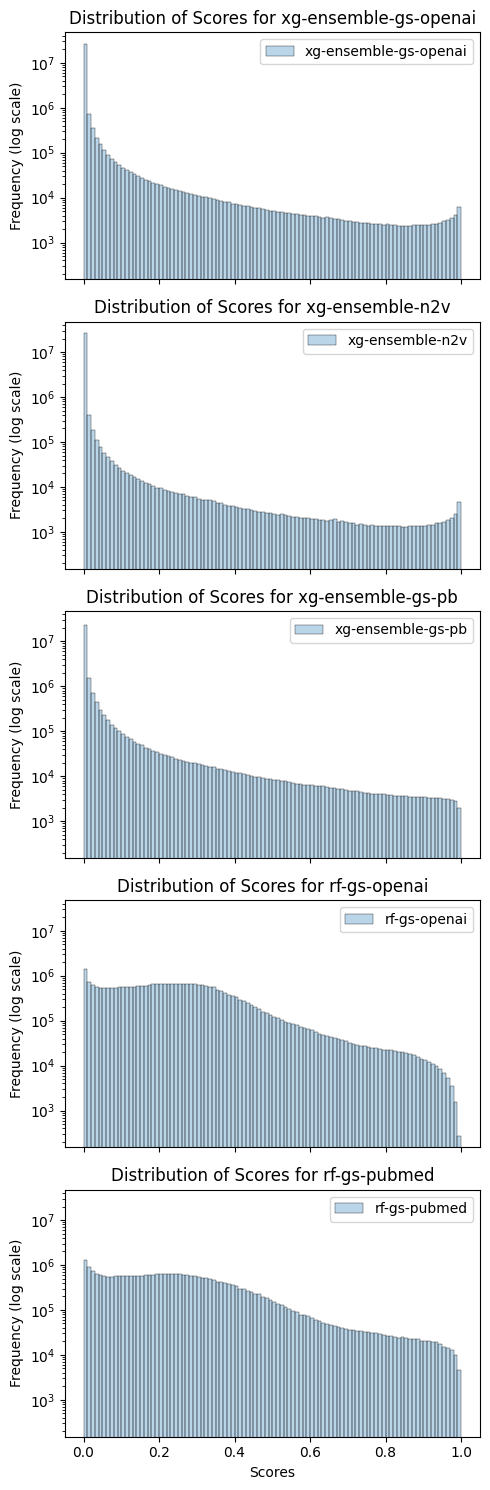

In [12]:
score_distribution(**run_dict)


Random Forest models lead to different score distribution than xg_ensemble models - they are less conservative. As random forest prove to have worse performance, we can assume that more conservative distribution is better - this would be in concert with node2vec result which is the best performing model so far. This is also consistent when you compare Node2Vec-XG-Ensemble vs OpenAI-GS-XG_Ensemble models which had the best performing stability metrics (F1, commonality, hypergeom).

100000


(<Figure size 1000x600 with 1 Axes>, <Figure size 500x1500 with 5 Axes>)

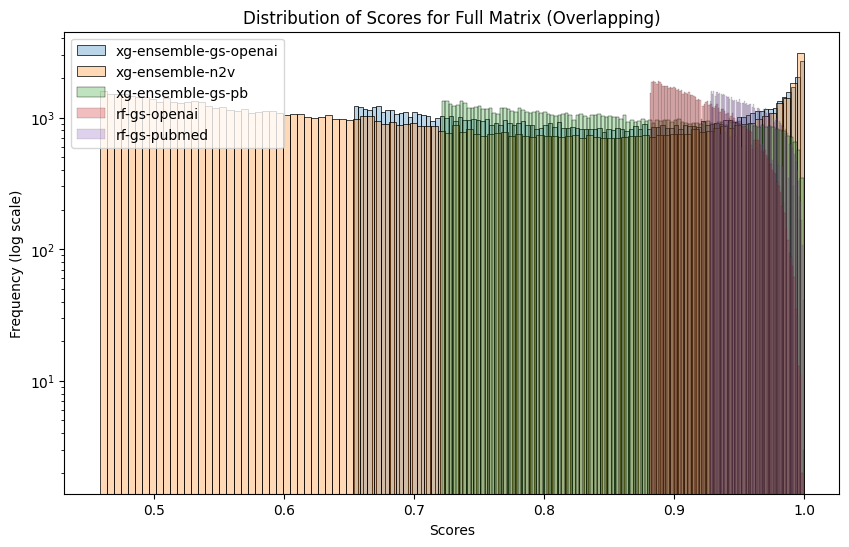

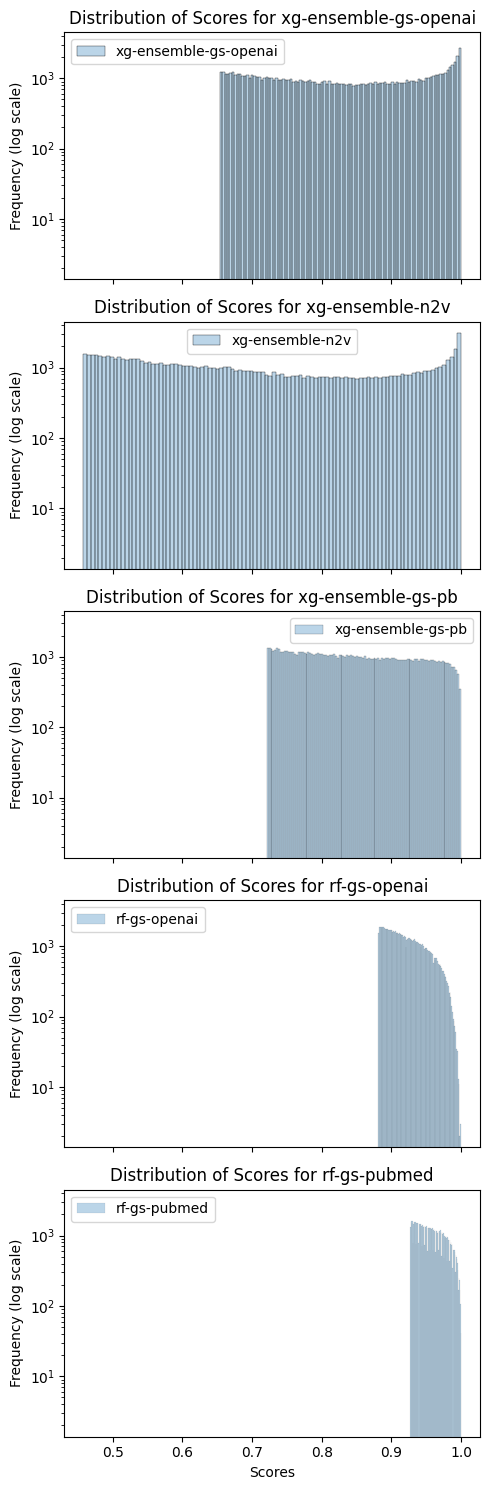

In [14]:
score_distribution(k=100000, **run_dict)


Interestingly, random forest models seem to predict all top 100k drug-disease pairs very highly, above 0.9 threshold while node2vec is much more conservative. In the full matrix ditribution we can also see the trend difference between random forest and xg ensemble models.

#### Conclusions
* Node2Vec consistently outperforms remaining modelling + embedding combinations
* PubMedBERT seems to perform worse than OpenAI across most metrics
* No significant correlation between any models
* commonality at k indicates that the highest overlap is achieved by two models which also achieved best evaluation metrics. Possibly one could be an indicator of anoteher
* hypergeometric test proves that the ranking of the drugs between all models is not random 
* distribution of treat score using random forest models is a bit too skewed towards 1.0 scores, while xg ensemble models are much more conservative (with Node2Vec being most conservative) 

Calculation of those stability metrics takes a while; parallelization would be needed -> pipeline in kedro so it can be executed on a cluster?